# Анализ данных из ClickHouse с использованием Pandahouse

## Датасет

Датасет `ldn_listings` содержит информацию о жилье на Airbnb в Лондоне. **Основные** столбцы включают:
- `price` – цена за ночь
- `room_type` – тип сдаваемого жилья
- `host_id` – идентификатор хозяина
- `host_verifications` – способы верификации хозяина
- `experiences_offered` – тип предлагаемых впечатлений
- `neighborhood` – район
- `review_scores_rating` – рейтинг
- `date_of_first_review` – дата первого отзыва

In [37]:
# Импортируем нужные библиотеки
import pandahouse as ph
import pandas as pd
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import numpy as np

In [38]:
# Объявляем параметры подключения
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

### 1 задание
Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы: price – цена за ночь, room_type – тип сдаваемого жилья
Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.



In [39]:
# Запрос на получение данных из clickhouse в pandas dataframe
query = """
SELECT room_type, 
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM default.ldn_listings
ORDER BY id
LIMIT 1000

"""
df = ph.read_clickhouse(query, connection=connection_default)
df.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0


In [40]:
room_type_quantile = df.groupby('room_type') \
                   .quantile(q=0.75)
room_type_quantile

,price
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


In [41]:
print(f'75 перцентиль цены для комнат типа Private room: {room_type_quantile.loc["Private room"]}')

75 перцентиль цены для комнат типа Private room: price    70.0
Name: Private room, dtype: float64


### 2 задание
1. Сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)
2. Используйте sns.scatterplot, чтобы построить график рассеивания средней цены и рейтинга c разбивкой по типу жилья 

In [42]:
query = """
SELECT room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
       toFloat32OrNull(replaceRegexpAll(review_scores_rating, '[$,]', '')) AS review_scores_rating
FROM default.ldn_listings
WHERE review_scores_rating IS NOT NULL
ORDER BY id
LIMIT 1000

"""
df2 = ph.read_clickhouse(query, connection=connection_default)
df2.head()

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [43]:
average_measures = df2.groupby('room_type') \
             .agg({'price':'mean',
                   'review_scores_rating':'mean'})
average_measures

,price,review_scores_rating
room_type,,
Entire home/apt,135.882950,93.568787
Hotel room,134.000000,92.500000
Private room,54.642437,94.766205
Shared room,21.000000,90.000000


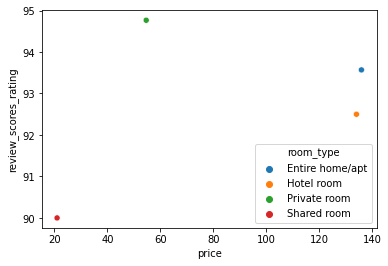

In [44]:
sns.scatterplot(data=average_measures, x="price", y="review_scores_rating", hue="room_type")

### 3 задание
Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:host_id, host_verifications 

Затем обработайте столбец host_verifications:
1. В ячейках находятся строковые представления списка. Приведите их к настоящему списку.
2. Посчитайте, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [45]:
query = """
SELECT DISTINCT host_id, 
       host_verifications
       
FROM default.ldn_listings
WHERE experiences_offered != 'none'

"""
df3 = ph.read_clickhouse(query, connection=connection_default)
df3.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [46]:
df3['host_verifications'] = df3['host_verifications'].apply(lambda x: x.replace("'", "").strip("[]").split(', '))

In [47]:
# Cначада переводем из одной строки со списком в несколько строк с ед. значением
veries = df3.explode(column='host_verifications') \
   .host_verifications.value_counts()
veries

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [48]:
print(f"{veries.loc['google']} хоста подтвердили профиль с помощью аккаунта Google.")

34 хоста подтвердили профиль с помощью аккаунта Google.


### 4 задание
Для скольких объявлений и в каких районах хозяева указали впечатления?

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью тепловой карты. 

In [70]:
query = """
SELECT neighbourhood_cleansed,
       experiences_offered,
       COUNT(id) AS experiences_count
FROM default.ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100

"""
df4 = ph.read_clickhouse(query, connection=connection_default)
df4.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [71]:
pivot_df = df4.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
pivot_df.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0


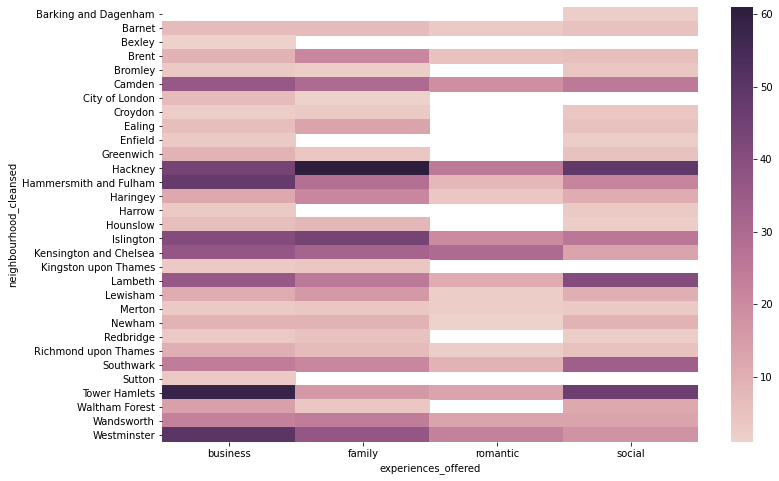

In [74]:
# Визуализиурем данные с помощью тепловой карты
plt.figure(figsize=(12, 8)) 
sns.heatmap(pivot_df, cmap=sns.cubehelix_palette(as_cmap=True))

### 5 задание
Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 

Далее постройте два графика: на первом отобразите исходные распределения цен для каждого типа жилья; на втором – логарифмированные значения.

In [75]:
query = """
SELECT room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM default.ldn_listings
WHERE experiences_offered != 'none'

"""
df5 = ph.read_clickhouse(query, connection=connection_default)
df5.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


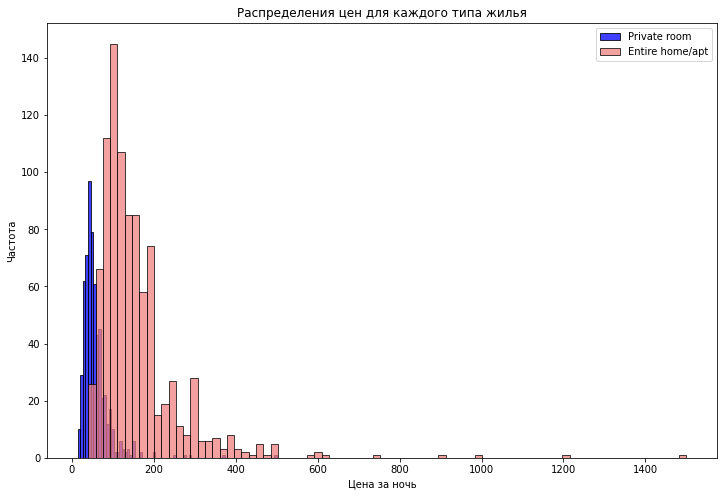

In [102]:
# График с исходными распределениями цен для каждого типа жилья
plt.figure(figsize=(12, 8))
sns.histplot(df5.query("room_type == 'Private room'").price, kde=False, label='Private room', color='blue')
sns.histplot(df5.query("room_type == 'Entire home/apt'").price, kde=False, label='Entire home/apt', color='lightcoral')
plt.xlabel('Цена за ночь')    
plt.ylabel('Частота')
plt.title('Распределения цен для каждого типа жилья')
plt.legend()
plt.show()

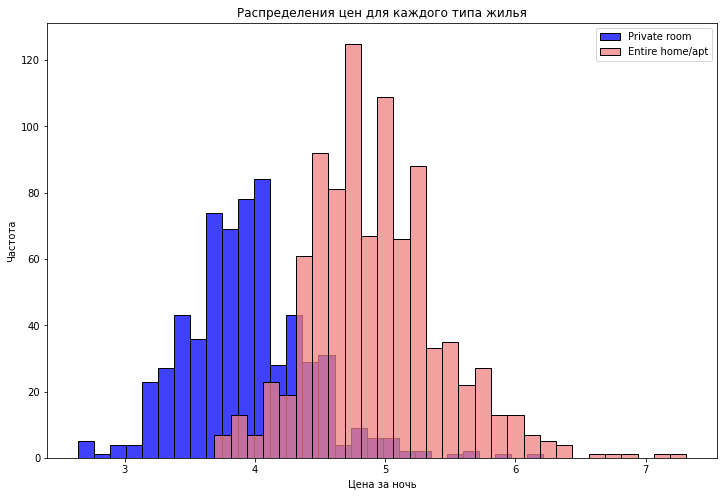

In [103]:
# График с логарифмированными значениями цен для каждого типа жилья
plt.figure(figsize=(12, 8))
sns.histplot(np.log(df5.query("room_type == 'Private room'").price), kde=False, label='Private room', color='blue')
sns.histplot(np.log(df5.query("room_type == 'Entire home/apt'").price), kde=False, label='Entire home/apt', color='lightcoral')
plt.xlabel('Цена за ночь')    
plt.ylabel('Частота')
plt.title('Распределения цен для каждого типа жилья')
plt.legend()
plt.show()

### 6 задание
Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Ограничение поставьте на 1000 строк.

Постройте график динамики средних цен на жилье в зависимости от типа комнаты по годам. Датафрейм должен быть отсортирован по годам.

In [98]:
query = """
SELECT room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
       first_review
FROM default.ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
df6 = ph.read_clickhouse(query, connection=connection_default)
df6.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [99]:
# Извлечем год из дат и создадим столбец для дальнейшей группировки
df6['first_review_year'] = df6['first_review'].apply(lambda x: x[:4])

In [106]:
average_by_type_year = df6.groupby(['room_type', 'first_review_year'], as_index=False) \
             .price.mean()
average_by_type_year.head()

,room_type,first_review_year,price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328


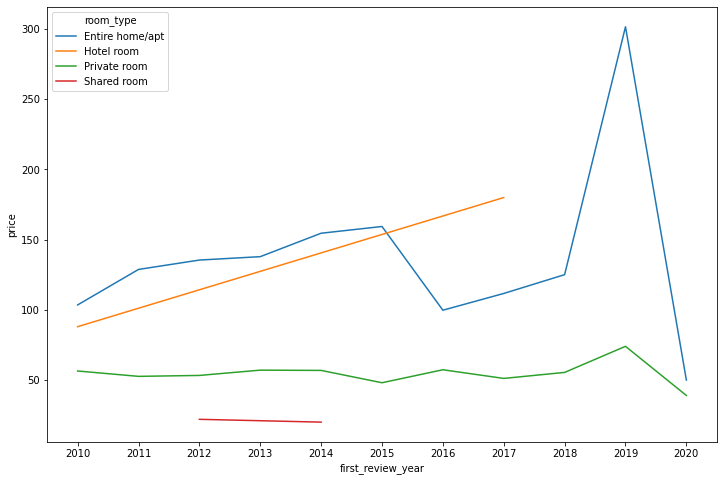

In [109]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review_year', y='price', hue='room_type',data=average_by_type_year)

**Основные выводы**:

- Entire home/apt:

Средняя цена для аренды целого дома или квартиры (Entire home/apt) имеет тенденцию к росту с 2010 по 2018 годы, достигнув пика в 2019 году, после чего резко падает в 2020 году.

- Hotel room:

Средняя цена для гостиничных номеров (Hotel room) демонстрирует стабильный и непрерывный рост на протяжении всех лет, что указывает на устойчивый спрос и, возможно, повышение уровня услуг.

- Private room:

Средняя цена для частных комнат (Private room) остается относительно стабильной с небольшими колебаниями. Значительных скачков или падений не наблюдается, что говорит о стабильной цене и, возможно, устоявшемся рынке.

- Shared room:

Средняя цена для общих комнат (Shared room) представлена только в определенные годы и показывает очень низкую стоимость. Поскольку данные для общих комнат отсутствуют в большинстве лет, можно предположить, что этот тип размещения либо не был популярен, либо данные по нему были недостаточны.

**Заключение**:
- Наибольшие колебания в цене наблюдаются у целых домов/квартир, особенно в последние годы.
- Гостиничные номера показывают устойчивый рост цен, что может свидетельствовать о повышении качества услуг или увеличении спроса.
- Частные комнаты остаются наиболее стабильным вариантом по цене.
- Общие комнаты либо не были популярны, либо данные по ним неполные.